WITH PHYSICS...

In [1]:
# Import libraries
import numpy as np
from scipy.constants import G # G=6.67408e-11, gravitational constant
import matplotlib.pyplot as plt

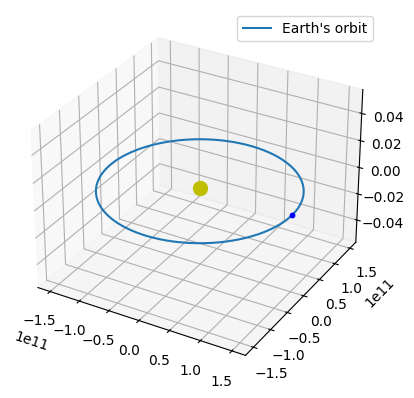

In [2]:
# Define constants of orbiting bodies (Sun and Earth) needed (SI units, m, kg, m/s)
m_sun = 1.98910e30
m_earth = 5.97237e24
rad_sun = 6.955e8
rad_earth = 6.371e6

# Define initial conditions
pos_sun = np.array([0.0, 0.0, 0.0])         # sun hardcoded to be at center of the coordinate system
pos_earth = np.array([1.496e11, 0.0, 0.0])  # 1 AU from sun
vel_earth = np.array([0.0, 2.978e4, 0.0])   # orbital speed of Earth (initial tangential velocity)

# Initial force & acceleration experienced by Earth
f_sunonearth = -G * m_earth * m_sun * (pos_earth-pos_sun) / (np.linalg.norm(pos_earth-pos_sun)**3) # "f_ES"
acc_earthfromsun = f_sunonearth / m_earth   #acc_12 = acceleration of object 1 due to object 2

# Update velocity & position by Euler's method
def update_pos_vel(pos, vel, acc):          # we want it to update every 1 day in simulation
    dt = 24*60*60                           # 1 day in seconds (because velocity is in m/s)
    vel += acc * dt
    pos += vel * dt
    return pos

# Simulate Earth's orbit
t = 365                                     # number of days to simulate (how many times to update position)
earth_poshistory = np.zeros((t, 3))
 
for n in range(0, t):
    earth_poshistory[n] = update_pos_vel(pos_earth, vel_earth, acc_earthfromsun)

    # Update force & acceleration based on new position
    f_sunonearth = -G*m_earth*m_sun * (earth_poshistory[n]-pos_sun) / (np.linalg.norm(earth_poshistory[n]-pos_sun)**3)
    acc_earthfromsun = f_sunonearth /m_earth

# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(pos_sun[0], pos_sun[1], pos_sun[2], color="y", s=100) # sun
ax.scatter(pos_earth[0], pos_earth[1], pos_earth[2], color="b", s=10) # earth
ax.plot(earth_poshistory[:, 0], earth_poshistory[:, 1], earth_poshistory[:, 2], label="Earth's orbit")

ax.legend()
plt.show()

In [3]:
# TO DO

# define position of the orbiting body relative to what it's orbiting
# generalise for any star-planet system
# not hardcode star's position
# add moon or satellite (3rd body)
# include gravitational influence of other bodies existing in the system
# make constants (mass, velocity) relative to each other to make simulation more useful... since it's not accurate anyways
# explain why dist_earth_sun != mag(pos_earth-pos_sun)
# incorporate the idea of orbits being elliptical - there are 2 foci

### test implementation of edits
orbital mechanics simulation with physics

In [4]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
# Physics engine: N body gravitational simulation

def calculate_accelerations(bodies, G = 1.0):
    """
    Calculate gravitational accelerations for all bodies.
    This includes ALL gravitational influences - each body feels the pull from every other body in the system (for accurate 3-body dynamics like Sun-Earth-Moon).
    
    Inputs:
        bodies: list of dicts with "mass", "pos", "vel"
        G: gravitational constant (dimensionless units)
    
    Returns:
        accelerations: list of 3D acceleration vectors
    """
    n = len(bodies)
    accelerations = [np.zeros(3) for _ in range(n)]
    
    # Calculate force (from each body on each other body)
    for i in range(n):
        for j in range(n):
            if i != j:
                # vector from body i to body j
                r_vec = bodies[j]["pos"] - bodies[i]["pos"]
                r_mag = np.linalg.norm(r_vec)
                
                if r_mag > 0:
                    # F = G*m1*m2/r² in direction of r_vec
                    # a = F/m1 = G*m2/r² in direction of r_vec
                    force_mag = G * bodies[i]["mass"] * bodies[j]["mass"] / (r_mag ** 2)
                    force_vec = force_mag * (r_vec / r_mag)
                    accelerations[i] += force_vec / bodies[i]["mass"]
    
    return accelerations


def integrate_leapfrog(bodies, dt, G = 1.0):
    """
    Leapfrog (Verlet) integration - better than Euler for calculation of orbits. It is a symplectic integrator that conserves energy well over long simulations, and is second-order accurate (as opposed to first-order for Euler).
    
    Inputs:
        bodies: list of body dicts (modified in place)
        dt: timestep
        G: gravitational constant
    """
    # Kick: half-step velocity update
    accelerations = calculate_accelerations(bodies, G)
    for i, body in enumerate(bodies):
        body["vel"] = body["vel"] + accelerations[i] * (dt / 2.0)
    
    # Drift: full-step position update
    for body in bodies:
        body["pos"] = body["pos"] + body["vel"] * dt
    
    # Kick: second half-step velocity update
    accelerations = calculate_accelerations(bodies, G)
    for i, body in enumerate(bodies):
        body["vel"] = body["vel"] + accelerations[i] * (dt / 2.0)

In [ ]:
# System initialisation (sun-moon-earth)

# dimensionless units to avoid numerical precision issues and slow simulation (timestep) issues that SI units would lead to
# units are relative, Sun has mass=1, distance of 1AU=10, G=1, time is relative...

# note: initial separation is not semi major axis (avg distance), we start at periapsis (closest approach) for elliptical orbits with e
# periapsis: r_peri = a(1-e)
# semi-major axis: a = r_peri/(1-e)
# special case of circular orbits (e=0): r_peri = a

def initialise_sun_earth_moon(earth_eccentricity=0.017, moon_eccentricity=0.055):
    """
    Initialise Sun-Earth-Moon system with dimensionless units. All pos relative to centre of mass (not hardcoded to Sun). Sun close to origin but wobbles due to gravitational influence of the other bodies.
    
    Inputs:
        earth_eccentricity: Earth's orbital eccentricity (real value ~0.017)
        moon_eccentricity: Moon's orbital eccentricity (real value ~0.055)
    
    Returns:
        bodies: list of body dicts
    """
    # Masses in relative units (Sun = 1.0)
    # Real ratios: Earth/Sun ≈ 3×10^-6, Moon/Earth ≈ 0.0123
    # Scale up Earth and Moon for visibility
    m_sun = 1.0
    m_earth = 0.003 # scaled up from 3×10^-6
    m_moon = 0.0001 # scaled up from 3.7×10^-8
    
    # Earth's orbit around Sun (starting at periapsis)
    earth_periapsis = 10.0 # distance units
    v_earth = np.sqrt(m_sun * (1 + earth_eccentricity) / earth_periapsis)
    
    # Initialise bodies
    sun = {
        "name": "Sun",
        "mass": m_sun,
        "pos": np.array([0.0, 0.0, 0.0]),
        "vel": np.array([0.0, 0.0, 0.0]),
        "color": "gold",
        "size": 100
    }
    
    earth = {
        "name": "Earth",
        "mass": m_earth,
        "pos": np.array([earth_periapsis, 0.0, 0.0]),
        "vel": np.array([0.0, v_earth, 0.0]),
        "color": "blue",
        "size": 50
    }
    
    # Moon's orbit around Earth (starting at periapsis relative to Earth)
    moon_periapsis = 0.3 # distance from Earth (scaled)
    v_moon_rel = np.sqrt(m_earth * (1 + moon_eccentricity) / moon_periapsis)
    
    moon = {
        "name": "Moon",
        "mass": m_moon,
        "pos": earth["pos"] + np.array([moon_periapsis, 0.0, 0.0]),
        "vel": earth["vel"] + np.array([0.0, v_moon_rel, 0.0]),
        "color": "orange",
        "size": 30
    }
    
    return [sun, earth, moon]


def initialise_general_system(central_mass=1.0, planet_mass=0.01, moon_mass=0.0001, planet_distance=10.0, moon_distance=0.3, planet_eccentricity=0.0, moon_eccentricity=0.0):
    """
    Generalised function for any 3 body star-planet-moon system, calculated based on physical principles.
    
    Inputs:
        central_mass: Mass of central star
        planet_mass: Mass of planet
        moon_mass: Mass of moon
        planet_distance: Planet's periapsis distance from star
        moon_distance: Moon's periapsis distance from planet
        planet_eccentricity: Planet's orbital eccentricity
        moon_eccentricity: Moon's orbital eccentricity
    
    Returns:
        bodies: list of body dicts
    """
    # Calculate velocities using vis-viva equation at periapsis
    v_planet = np.sqrt(central_mass * (1 + planet_eccentricity) / planet_distance)
    v_moon_rel = np.sqrt(planet_mass * (1 + moon_eccentricity) / moon_distance)
    
    star = {
        "name": "Star",
        "mass": central_mass,
        "pos": np.array([0.0, 0.0, 0.0]),
        "vel": np.array([0.0, 0.0, 0.0]),
        "color": "yellow",
        "size": 100
    }
    
    planet = {
        "name": "Planet",
        "mass": planet_mass,
        "pos": np.array([planet_distance, 0.0, 0.0]),
        "vel": np.array([0.0, v_planet, 0.0]),
        "color": "blue",
        "size": 50
    }
    
    moon = {
        "name": "Moon",
        "mass": moon_mass,
        "pos": planet["pos"] + np.array([moon_distance, 0.0, 0.0]),
        "vel": planet["vel"] + np.array([0.0, v_moon_rel, 0.0]),
        "color": "orange",
        "size": 30
    }
    
    return [star, planet, moon]

In [ ]:
# RUN SIMULATION

# Initialise system

# Option 1: Sun-Earth-Moon
bodies = initialise_sun_earth_moon(earth_eccentricity=0.017, moon_eccentricity=0.055)

# Option 2: General system with custom parameters
# bodies = initialise_general_system(
#     central_mass=1.0, 
#     planet_mass=0.01, 
#     moon_mass=0.001,
#     planet_distance=10.0,
#     moon_distance=0.5,
#     planet_eccentricity=0.1,
#     moon_eccentricity=0.2
# )

# Calculate timestep based on shortest orbital period
# For Sun-Earth-Moon: Moon orbits Earth fastest, so base dt on that
moon_period = 2 * np.pi * np.sqrt(0.3**3 / 0.003) # rough estimate
dt = moon_period / 200 # 200 steps per moon orbit

print(f"Simulating {len(bodies)}-body system:")
for body in bodies:
    print(f"  {body["name"]}: mass={body["mass"]:.6f}")
print(f"Timestep: {dt:.6f}")
print()

# Simulate
n_steps = 2000 # number of timesteps
history = {i: {"pos": [], "vel": []} for i in range(len(bodies))}

for step in range(n_steps):
    # Store current state
    for i, body in enumerate(bodies):
        history[i]["pos"].append(body["pos"].copy())
        history[i]["vel"].append(body["vel"].copy())
    
    # Update physics
    integrate_leapfrog(bodies, dt)
    
    if (step + 1) % 500 == 0:
        print(f"Step {step + 1}/{n_steps} completed")

# Convert to numpy arrays for plotting
for i in range(len(bodies)):
    history[i]["pos"] = np.array(history[i]["pos"])
    history[i]["vel"] = np.array(history[i]["vel"])

Simulating 3-body system:
  Sun: mass=1.000000
  Earth: mass=0.003000
  Moon: mass=0.000100
Timestep: 0.094248

Step 500/2000 completed
Step 1000/2000 completed
Step 1500/2000 completed
Step 2000/2000 completed


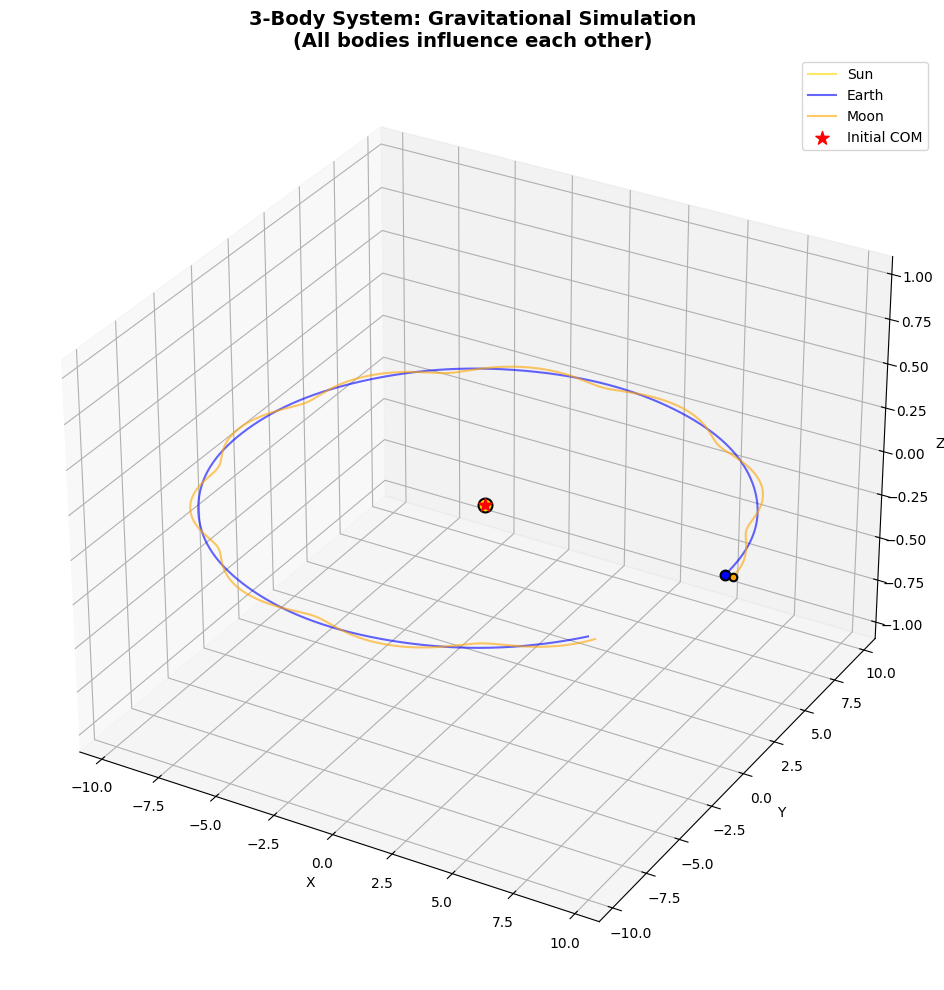

In [ ]:
# RESULTS VISUALISATION

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot orbits
for i, body in enumerate(bodies):
    positions = history[i]["pos"]
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 
           color=body["color"], alpha=0.6, linewidth=1.5, label=body["name"])
    
    # Plot starting position
    ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2],
              color=body["color"], s=body["size"], marker='o', edgecolors="black", linewidths=1.5)

# Mark the origin (initial center of mass)
ax.scatter([0], [0], [0], color="red", s=100, marker='*', label="Initial COM")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3-Body System: Gravitational Simulation\n(All bodies influence each other)", 
            fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

# Set equal aspect ratio
max_range = max(
    np.abs(history[i]["pos"]).max() for i in range(len(bodies))
)
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range/10, max_range/10])

plt.tight_layout()
plt.show()

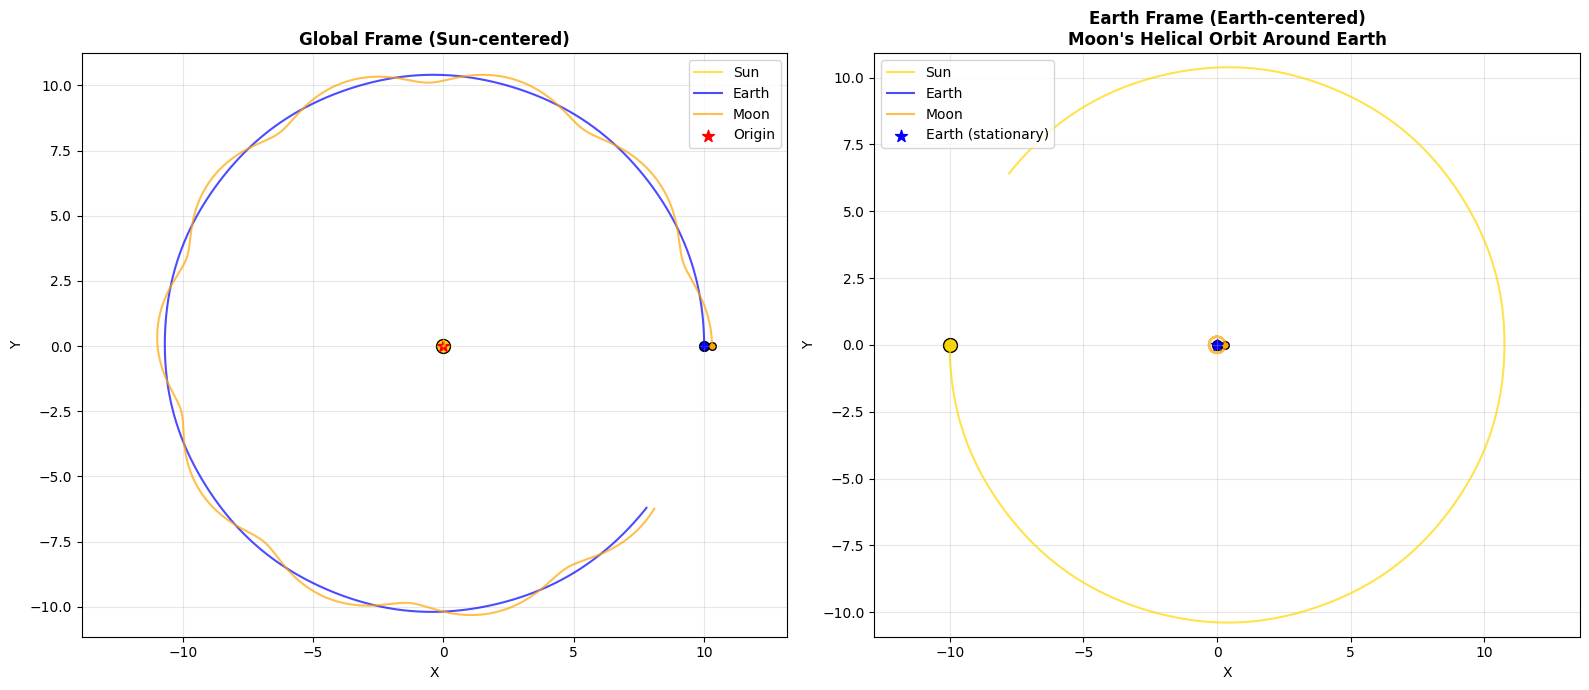

In [ ]:
# VIEWING (different reference frames)

# Plot in Earth's reference frame to see Moon's orbit clearly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left: Sun's frame (global)
for i, body in enumerate(bodies):
    positions = history[i]["pos"]
    ax1.plot(positions[:, 0], positions[:, 1], 
            color=body["color"], alpha=0.7, linewidth=1.5, label=body["name"])
    ax1.scatter(positions[0, 0], positions[0, 1],
               color=body["color"], s=body["size"], edgecolors="black", linewidths=1)

ax1.scatter([0], [0], color="red", s=80, marker='*', label="Origin")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_title("Global Frame (Sun-centered)", fontsize=12, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis("equal")

# Right: Earth's frame
earth_idx = 1 # Earth is the second body
earth_positions = history[earth_idx]["pos"]

for i, body in enumerate(bodies):
    # Transform to Earth's reference frame
    positions_relative = history[i]["pos"] - earth_positions
    ax2.plot(positions_relative[:, 0], positions_relative[:, 1], 
            color=body["color"], alpha=0.7, linewidth=1.5, label=body["name"])
    ax2.scatter(positions_relative[0, 0], positions_relative[0, 1],
               color=body["color"], s=body["size"], edgecolors="black", linewidths=1)

ax2.scatter([0], [0], color="blue", s=80, marker='*', label="Earth (stationary)")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_title("Earth Frame (Earth-centered)\nMoon's Helical Orbit Around Earth", 
             fontsize=12, fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axis("equal")

plt.tight_layout()
plt.show()

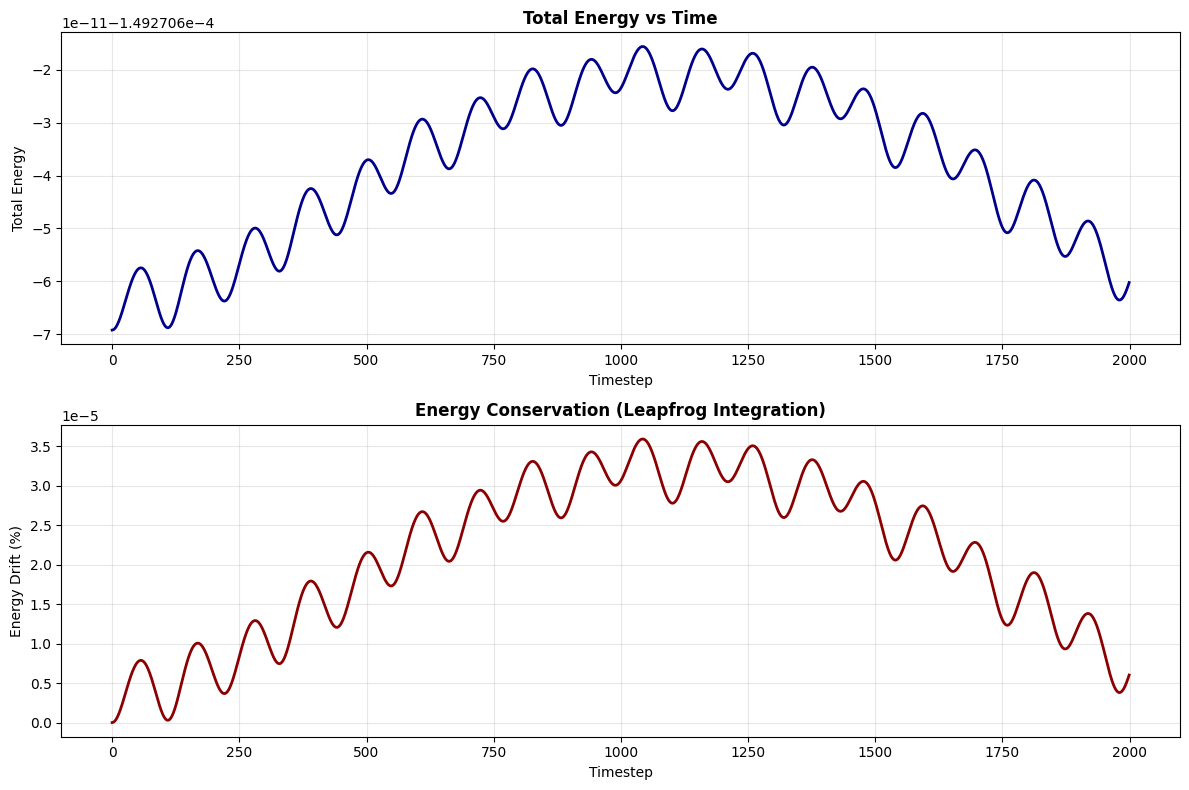

Initial energy: -0.000149
Final energy: -0.000149
Energy drift: 0.0000%


In [ ]:
# extra analysis of energy and momentum conservation

def calculate_energy(bodies_history, bodies_info, G=1.0):
    """
    Calculate total energy (kinetic + potential) at each timestep.
    """
    n_steps = len(bodies_history[0]["pos"])
    n_bodies = len(bodies_info)
    
    energies = []
    
    for step in range(n_steps):
        # Kinetic energy
        KE = 0
        for i in range(n_bodies):
            vel = bodies_history[i]["vel"][step]
            KE += 0.5 * bodies_info[i]["mass"] * np.dot(vel, vel)
        
        # Potential energy
        PE = 0
        for i in range(n_bodies):
            for j in range(i + 1, n_bodies):
                pos_i = bodies_history[i]["pos"][step]
                pos_j = bodies_history[j]["pos"][step]
                r = np.linalg.norm(pos_j - pos_i)
                PE -= G * bodies_info[i]["mass"] * bodies_info[j]["mass"] / r
        
        energies.append(KE + PE)
    
    return np.array(energies)

# Calculate energy over time
energies = calculate_energy(history, bodies)
energy_drift = (energies - energies[0]) / np.abs(energies[0]) * 100

# Plot energy conservation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(energies, color="darkblue", linewidth=2)
ax1.set_xlabel("Timestep")
ax1.set_ylabel("Total Energy")
ax1.set_title("Total Energy vs Time", fontsize=12, fontweight="bold")
ax1.grid(True, alpha=0.3)

ax2.plot(energy_drift, color="darkred", linewidth=2)
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Energy Drift (%)")
ax2.set_title("Energy Conservation (Leapfrog Integration)", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial energy: {energies[0]:.6f}")
print(f"Final energy: {energies[-1]:.6f}")
print(f"Energy drift: {energy_drift[-1]:.4f}%") # leapfrog is good for energy conservation

Notes:
* position (eg. of moon) is relative to what the body is orbiting
    * moon's position is initialised as `earth_pos + moon_offset`
    * moon's velocity is `earth_vel + moon_vel_relative`
    * ensures moon won't orbit origin
* `initialise_general_system()` is generalised to work with any star-planet-moon (3 body) configuration
* star position is not hardcoded (sun exists at origin but is free to move ie. motion due to gravity of other bodies - barycentric motion)
* can extend to more bodies
    * `calculate_accelerations()` includes all body-body interactions
* everything scaled relative to sun mass and distance of 1AU (but can be changed)
* eccentricity param for control of orbit shape
* velocity at periapsis: `v = sqrt(GM*(1+e)/r_peri)`
